# ============================================
# STEP 4: CASE STUDY - DATA ANALYSIS
# ============================================
## Projet : Amazon Review Analysis - Snowflake Edition
## Objectif : Analyse et catégorisation des avis utilisateurs avec algorithmes NLP
## Date : 2025-11-03
# ============================================

## 📋 TABLE DES MATIÈRES

1. [Introduction & Contexte du Case Study](#1-introduction)
2. [Configuration & Connexion aux Données](#2-configuration)
3. [Extraction des Données depuis Snowflake](#3-extraction)
4. [Analyse Exploratoire des Données (EDA)](#4-eda)
5. [Choix & Justification de l'Algorithme](#5-algorithme)
6. [Implémentation du Modèle NLP](#6-implementation)
7. [Vérification du Fonctionnement (Convergence & Performance)](#7-verification)
8. [Tests Itératifs & Affinage des Critères](#8-affinage)
9. [Calcul du Relevance Score Final](#9-relevance)
10. [Visualisations & Insights Business](#10-visualisations)
11. [Préparation des Données pour le Dashboard Streamlit](#11-dashboard)
12. [Limitations & Recommandations](#12-limitations)
13. [Livrables & Export](#13-livrables)

---
## 1️⃣ INTRODUCTION & CONTEXTE DU CASE STUDY {#1-introduction}

### 1.1 Contexte Business

Dans le cadre de l'amélioration de l'expérience utilisateur sur les plateformes e-commerce, Amazon reçoit quotidiennement des millions de commentaires clients sur des produits. Face à ce volume massif d'avis, il devient crucial pour les consommateurs de pouvoir identifier rapidement les commentaires les plus pertinents et informatifs.

**Problématique** : Identification automatique des reviews pertinentes sur Amazon  
**Objectif** : Catégorisation thématique + Scoring de pertinence  
**Périmètre** : Données extraites de Snowflake (Step 3 - ETL terminé)

### 1.2 Objectifs de l'Analyse

- **Objectif 1** : Classer les reviews en catégories métier (NLP zero-shot classification)
- **Objectif 2** : Développer un relevance score multi-critères (0-100)
- **Objectif 3** : Produire des insights actionnables pour le business

### 1.3 Questions de Recherche

- Quelles thématiques dominent les avis clients ?
- Quels critères influencent la pertinence d'une review ?
- Comment optimiser l'expérience utilisateur via l'analyse de sentiment ?

### 1.4 Méthodologie Globale

**Pipeline** : Snowflake → Extraction → NLP Classification → Relevance Scoring → Dashboard

```
┌──────────────┐      ┌─────────────┐      ┌──────────────┐      ┌──────────────┐
│  Snowflake   │ ───> │ Zero-Shot   │ ───> │  Relevance   │ ───> │  Streamlit   │
│  (Reviews)   │      │    NLP      │      │   Scoring    │      │  Dashboard   │
└──────────────┘      └─────────────┘      └──────────────┘      └──────────────┘
```

---
## 2️⃣ CONFIGURATION & CONNEXION AUX DONNÉES {#2-configuration}

### 2.1 Installation des Dépendances

In [ ]:
# Cell: Installation des packages (à exécuter une fois)
# !pip install snowflake-connector-python
# !pip install transformers torch
# !pip install nltk pandas numpy matplotlib seaborn plotly

### 2.2 Import des Bibliothèques

In [1]:
# ============================================
# Imports des bibliothèques principales
# ============================================
import snowflake.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from dotenv import load_dotenv
import os
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# from transformers import pipeline


import warnings

load_dotenv() 

# NLP Libraries (décommenter après installation)
# from transformers import pipeline
# import torch
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

print("Bibliothèques importées avec succès")

Bibliothèques importées avec succès


### 2.3 Connexion à Snowflake

In [3]:
# ============================================
# Connexion à Snowflake
# ============================================
# TODO: Remplacer par vos credentials Snowflake

conn_params = {
    'account': os.getenv('SNOWFLAKE_ACCOUNT'),
    'user': os.getenv('SNOWFLAKE_USER'),
    'password': os.getenv('SNOWFLAKE_PASSWORD'),
    'warehouse': os.getenv('SNOWFLAKE_WAREHOUSE'),
    'database': os.getenv('SNOWFLAKE_DATABASE'),
    'schema': os.getenv('SNOWFLAKE_SCHEMA_STAGING'),
    'role': os.getenv('SNOWFLAKE_ROLE')
}

try:
    conn = snowflake.connector.connect(**conn_params)
    print("Connexion Snowflake établie avec succès")
    cursor = conn.cursor()

    #créer les schémas si ils n'existent pas 
    cursor.execute("CREATE SCHEMA IF NOT EXISTS STAGING")
    cursor.execute("CREATE SCHEMA IF NOT EXISTS ANALYTICS")
    print("SCHEMA ANALYTICS ET STAGING CREE AVEC SUCCES")
    # Afficher les tables disponibles
    cursor = conn.cursor()
    cursor.execute("SHOW TABLES")
    tables = cursor.fetchall()
    print(f"\nTables disponibles : {len(tables)}")
    for table in tables:
        print(f"  - {table[1]}")
    
except Exception as e:
    print(f"Erreur de connexion : {e}")
    raise

Connexion Snowflake établie avec succès
SCHEMA ANALYTICS ET STAGING CREE AVEC SUCCES

Tables disponibles : 2
  - REVIEWS
  - REVIEW_RELEVANT


---
## 3️⃣ EXTRACTION DES DONNÉES DEPUIS SNOWFLAKE {#3-extraction}

### 3.1 Requête SQL : Sélection des reviews

**Objectif** : Récupèrer les avis des client afin de les analyser.

In [ ]:
# ============================================
# SQL - Top produits par volume de reviews
# ============================================

try:
    # SQL query to retrieve review data
    query = """
        SELECT 
            REVIEW_ID, 
            BUYER_ID, 
            P_ID, 
            PRODUCT_NAME, 
            CATEGORY, 
            TITLE, 
            DESCRIPTION, 
            RATING, 
            TEXT_LENGTH, 
            HAS_IMAGE, 
            HAS_ORDERS
        FROM REVIEWS;
    """

    print("Fetching data from Snowflake...")

    # Execute the query and store the result in a Pandas DataFrame
    df_reviews = pd.read_sql(query, conn)

    print("Data successfully retrieved!")
    
    # Display the first few rows for a quick preview
    display(df_reviews.sample(5))

except Exception as e:
    # Catch and print any error that occurs during execution
    print(f"Error while retrieving data: {e}")
    raise


### 3.1 Algorithme 1 : Calcul de score

**Objectif** : Calcul des scores de pertinence à l'aide de mesures textuelles, d'analyses des sentiments et d'attributs d'évaluation.

In [ ]:
# ============================================
# Algorithme 1 : Calculate score
# ============================================

# Download the VADER sentiment lexicon (required for sentiment scoring)
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


# 1. text_length_score (Gaussian-based scoring function)
def calculate_text_length_score(length):
    """
    Computes a score based on how close the text length is to an optimal value.
    Uses a Gaussian function centered at 'optimal'.
    """
    optimal = 300     # ideal review length
    sigma = 200       # acceptable deviation range
    return np.exp(-((length - optimal)**2) / (2 * sigma**2))


# Apply the text length score to each review
df_reviews['TEXT_LENGTH_SCORE'] = df_reviews['TEXT_LENGTH'].apply(calculate_text_length_score)


# 2. is_extreme_rating (checks whether the rating is 1 or 5)
df_reviews['IS_EXTREME_RATING'] = df_reviews['RATING'].apply(lambda x: 1 if x in [1, 5] else 0)


# 3. sentiment_score (replaces keyword_score)
def sentiment_score(text):
    """
    Computes the sentiment score of review text using VADER.
    Output is normalized between 0 and 1.
    """
    if pd.isna(text):
        return 0.0
    score = analyzer.polarity_scores(text)['compound']
    return (score + 1) / 2  # normalize from [-1,1] to [0,1]


# Apply sentiment scoring to the review description
df_reviews['KEYWORD_SCORE'] = df_reviews['DESCRIPTION'].apply(sentiment_score)


# Compute the final relevance_score using weighted components
df_reviews['RELEVANCE_SCORE'] = (
    0.30 * df_reviews['TEXT_LENGTH_SCORE'] +
    0.20 * df_reviews['HAS_IMAGE'] +
    0.10 * df_reviews['HAS_ORDERS'] +
    0.15 * df_reviews['IS_EXTREME_RATING'] +
    0.25 * df_reviews['KEYWORD_SCORE']
) * 100  # scale to 0–100


print("Relevance score computation completed successfully.")

### 3.1 Algorithme 2 : Zéro-Shot

Dans cette étape, nous allons utiliser un modèle de classification zero-shot basé sur mDeBERTa, capable d’analyser des textes en plusieurs langues sans nécessiter d’entraînement supplémentaire.

**Objectif** : L’objectif est de déterminer automatiquement la catégorie associée à chaque review client (qualité produit, problème de livraison, service client, etc.).
Nous appliquons ensuite cette classification à l’ensemble des données et calculons également un score de confiance indiquant la certitude du modèle pour chaque prédiction.

In [ ]:
# # Load a multilingual zero-shot classification model
# classifier = pipeline(
#     "zero-shot-classification",
#     model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
#     device=0  # Use GPU if available, otherwise fallback to CPU
# )

# # Define the possible categories the classifier should choose from
# candidate_labels = [
#     "product quality or satisfaction",
#     "product defect or damaged item",
#     "delivery issue or shipping delay",
#     "customer service or support"
# ]

# print(f"Model loaded - {len(candidate_labels)} categories defined")


# # Function to classify a single review
# def classify_review(text):
#     """
#     Returns the predicted category and confidence score for a given text.
#     If the text is empty or missing, returns (None, 0.0).
#     """
#     if pd.isna(text) or text.strip() == "":
#         return None, 0.0

#     # Run zero-shot classification on the given text
#     result = classifier(text, candidate_labels)

#     # The model returns labels sorted by highest probability first
#     predicted_label = result['labels'][0]
#     confidence = result['scores'][0]

#     return predicted_label, confidence


# print(f"Classifying {len(df_reviews)} reviews...")

# # Apply the classification function to all review descriptions
# df_reviews[['category_review', 'confidence_score']] = df_reviews['DESCRIPTION'].apply(
#     lambda x: pd.Series(classify_review(x))
# )

# print("\nClassification completed")

# # Display distribution of predicted categories
# print("\nCategory distribution:")
# print(df_reviews['category_review'].value_counts())

# # Display average confidence score
# print(f"\nAverage confidence score: {df_reviews['confidence_score'].mean():.3f}")

### 3.1.1 Algorithme Zéro-Shot : Optimisation du temps de traitement et utilisation d’un fichier pré-calculé

L’algorithme de zero-shot classification que nous avons utilisé repose sur un modèle mDeBERTa multilingue. Bien qu’il soit très performant, ce type de modèle nécessite un temps de calcul important : il lui a fallu près de 3 heures pour analyser l’ensemble des 111 322 reviews et attribuer une catégorie à chacune.

Afin d’optimiser le temps d’exécution pour la suite du projet et d’éviter de relancer ce traitement lourd à chaque exécution du notebook, nous avons exporté les résultats de la classification dans un fichier CSV pré-calculé.
Désormais, nous chargerons directement ce fichier pour continuer nos analyses.

À partir de cette étape, nous nous baserons donc sur ce fichier CSV déjà enrichi pour effectuer les transformations finales et réinjecter les données préparées dans Snowflake. Cela nous permet de travailler plus rapidement tout en conservant des résultats fiables issus du modèle.

In [4]:
df_reviews_calculated = pd.read_csv('data/df_relevant_reviews.csv')
# For the next step, I need the CONFIDENCE_SCORE and RELEVANCE_SCORE columns to be in %.
# In this case, I multiply CONFIDENCE_SCORE *100.
df_reviews_calculated['CONFIDENCE_SCORE'] =df_reviews_calculated['CONFIDENCE_SCORE']*100
df_reviews_calculated.head(5)

,REVIEW_ID,BUYER_ID,P_ID,PRODUCT_NAME,CATEGORY,TITLE,DESCRIPTION,RATING,TEXT_LENGTH,HAS_IMAGE,HAS_ORDERS,TEXT_LENGTH_SCORE,IS_EXTREME_RATING,KEYWORD_SCORE,RELEVANCE_SCORE,CATEGORY_REVIEW,CONFIDENCE_SCORE
0,96008,1d9275fd930c2c9b08cb4a162b576e6ce21ee7359b3d6e...,B078WYZK74,Camille Beckman All Natural Cocoa Butter Lip B...,All Beauty,A Great Product,"I bought one and after trying it, I bought thr...",5,87,False,True,0.567161,1,0.50000,54.514823,product quality or satisfaction,40.748632
1,96016,1e5631dbed5a85bfe3749aea4180b5835597ab5e871d19...,B01M1OBRBQ,"Real Techniques Bold Metals: Diamond Sponge, C...",All Beauty,Diamonds,I usually use the orange Real Techniques makeu...,5,376,False,True,0.930345,1,0.95925,76.891594,product quality or satisfaction,93.760085
2,96024,f47cabedd39f9910b1a58acc2f31b39c20b05e9a56e021...,B07GRQ1FZ3,Sedittyhair 18 inch 6 Packs Dreadlocks Hair Ex...,All Beauty,This is not wj,This hair is the worst ever..all the ends came...,1,51,False,True,0.460698,1,0.18755,43.509691,product defect or damaged item,81.325984
3,96032,bffaf03ba478b912aa7d8e86f247cd5b5f76ccdb87d690...,B010HW5HV2,Mokale 6 Pcs Transparent Salon Croc Clips Hair...,All Beauty,Four Stars,they work for my daughter !,4,27,False,True,0.393918,0,0.50000,34.317540,product quality or satisfaction,40.620098
4,96040,f715b2dd72adfaa3967b92fa2abc16cb03c69583a9feef...,B01JOKTHE6,Nakeup Face 8 Days Tattoo EyeBrow No.01 Light ...,All Beauty,Two Stars,Doesn't last,2,12,False,True,0.354588,0,0.50000,33.137626,product defect or damaged item,55.851531


In [4]:
df_reviews_calculated.shape

(111185, 17)

#### 3.2 Définition des seuils

Afin de déterminer si un avis est considéré comme pertinent ou non, nous devons définir des seuils basés sur deux indicateurs clés :
* CONFIDENCE_SCORE : le niveau de confiance du modèle dans la classification zero-shot.
* RELEVANCE_SCORE : le score global calculé précédemment, représentant la qualité et l’utilité potentielle de l’avis.

Pour garantir un niveau élevé de fiabilité, nous allons procéder à l'analyse de nos résultats.


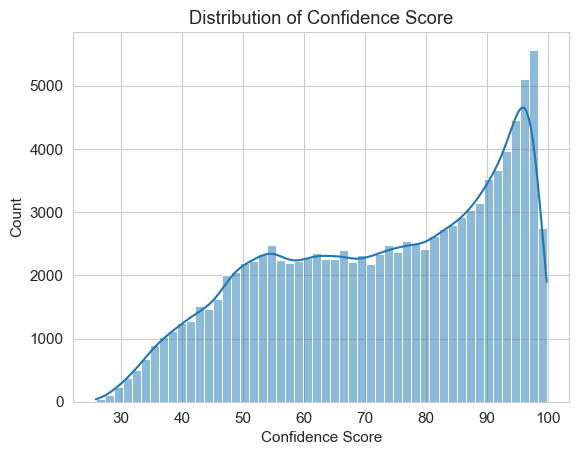

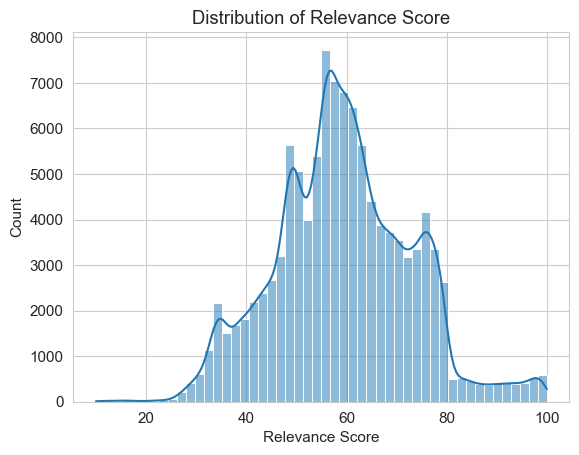

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confidence score distribution
sns.histplot(df_reviews_calculated['CONFIDENCE_SCORE'], bins=50, kde=True)
plt.title("Distribution of Confidence Score")
plt.xlabel("Confidence Score")
plt.show()

# Relevance score distribution
sns.histplot(df_reviews_calculated['RELEVANCE_SCORE'], bins=50, kde=True)
plt.title("Distribution of Relevance Score")
plt.xlabel("Relevance Score")
plt.show()


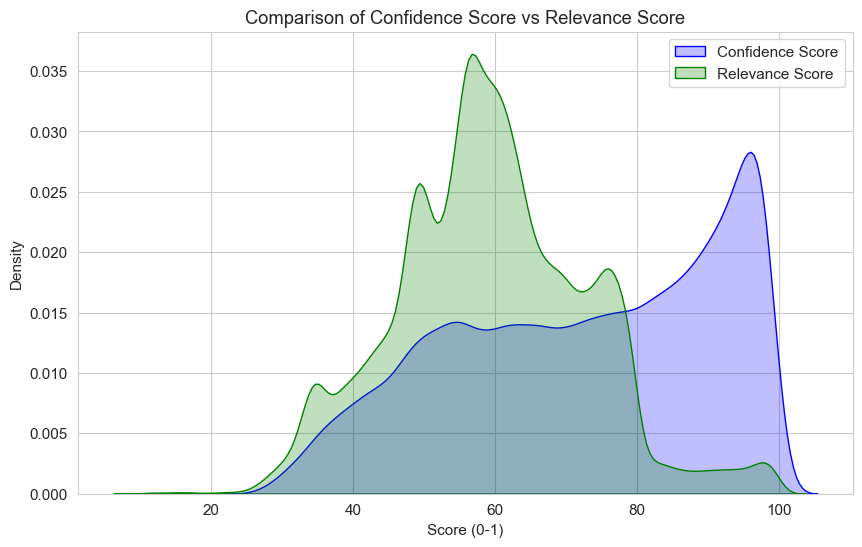

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10,6))

# Plot the distribution of Confidence Score
sns.kdeplot(df_reviews_calculated['CONFIDENCE_SCORE'], fill=True, label='Confidence Score', color='blue')

# Plot the distribution of Relevance Score
sns.kdeplot(df_reviews_calculated['RELEVANCE_SCORE'], fill=True, label='Relevance Score', color='green')

# Add titles and labels
plt.title("Comparison of Confidence Score vs Relevance Score")
plt.xlabel("Score (0-1)")
plt.ylabel("Density")
plt.legend()
plt.show()


### 📊 3.2.1 Disptribution des scores

- CONFIDENCE_SCORE
- RELEVANCE_SCORE

#### Interprétation des résultats
Confidence Score (bleu) :
* Pic vers ~95 → la majorité des avis ont un score de confiance élevé.
* Courbe étalée de 40 à 100 → quelques avis ont une confiance plus faible.
* Cela montre que le modèle est plutôt sûr sur la plupart des avis.

Relevance Score (vert) :
* Pic principal vers 60 → la majorité des avis ont une pertinence moyenne.
* Distribution plus étalée et parfois basse → certains avis sont peu pertinents selon le calcul des scores (text length, sentiment, image…).
* Il y a un creux autour de 80-85 → ça peut être un point pour tester un seuil naturel.

Density : le pic observé de la densité est de 0,035, cela signifie que les données sont trés étalées.
Plus la densité maximale est faible, plus les valeurs sont dispersées.
Plus la densité maximale est elevée, plus les valeurs sont concentrées autour d'un point.


#### Fixer un premier seuil
* Confidence Score : la densité élevée autour de 95 → un seuil >70 ou >80 retient la plupart des avis “sûrs”. On part sur 70%
* Relevance Score : la densité est centrée autour de 60 → un seuil de 70 capture les avis au-dessus de la moyenne, mais on perd une partie du volume. On part dans un premier temps sur 50%

La combinaison suivante des deux, peut sembler raisonable pour capturer une bonne partie des avis :
* Confidence Score ≥ 70%.
* Relevance Score ≥ 50%.

Nous allons tout de même continuer l'analyse pour affiner ces deux paramètres.

### 📊 3.2.2 Quantité d'avis exclus

Dans la première analyse, nous nous intéressons à la distribution des avis selon les scores. Toutefois, est-ce que cette distribution et les seuils définis ne seraient pas très restrictifs ? Combien de données sommes-nous capables de capturer si nous partons sur cette distribution ?
* Confidence Score > 70%.
* Relevance Score > 50%.

Est-ce que c'est la meilleure distribution ? C'est ce que  nous allons analyser dans cette section.

Maintenant, nous allons analyser combien d'avis nous pouvons capturer sur plusieurs tests et chaque test va nous renvoyer les seuils associés.

In [7]:
# Choisis tes seuils (exemple avec top 25%)

# TEST 1
print('-------------------------------')
print("CONFIDENCE_SCORE -> TOP 25%")
print("RELEVANCE_SCORE -> TOP 25%")
confidence_threshold = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.75)
relevance_threshold = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.75)

# Affichage des seuils
print(f"🎯 Seuil CONFIDENCE_SCORE: {confidence_threshold:.3f}")
print(f"🎯 Seuil RELEVANCE_SCORE: {relevance_threshold:.3f}")

# Filtre tes données
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= confidence_threshold) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= relevance_threshold)
]

print(f"📊 Données originales: {len(df_reviews_calculated)}")
print(f"✅ Données conservées: {len(df_filtered)} ({len(df_filtered)/len(df_reviews_calculated)*100:.1f}%)")
print(f"❌ Données écartées: {len(df_reviews_calculated) - len(df_filtered)}")

# TEST 2
print('-------------------------------')
print("CONFIDENCE_SCORE -> TOP 50%")
print("RELEVANCE_SCORE -> TOP 50%")
confidence_threshold = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.50)
relevance_threshold = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.50)

# Affichage des seuils
print(f"🎯 Seuil CONFIDENCE_SCORE: {confidence_threshold:.3f}")
print(f"🎯 Seuil RELEVANCE_SCORE: {relevance_threshold:.3f}")

# Filtre tes données
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= confidence_threshold) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= relevance_threshold)
]

print(f"📊 Données originales: {len(df_reviews_calculated)}")
print(f"✅ Données conservées: {len(df_filtered)} ({len(df_filtered)/len(df_reviews_calculated)*100:.1f}%)")
print(f"❌ Données écartées: {len(df_reviews_calculated) - len(df_filtered)}")


# TEST 3
print('-------------------------------')
print("CONFIDENCE_SCORE -> TOP 40%")
print("RELEVANCE_SCORE -> TOP 50%")
confidence_threshold = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.60)
relevance_threshold = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.50)

# Affichage des seuils
print(f"🎯 Seuil CONFIDENCE_SCORE: {confidence_threshold:.3f}")
print(f"🎯 Seuil RELEVANCE_SCORE: {relevance_threshold:.3f}")
# Filtre tes données
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= confidence_threshold) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= relevance_threshold)
]

print(f"📊 Données originales: {len(df_reviews_calculated)}")
print(f"✅ Données conservées: {len(df_filtered)} ({len(df_filtered)/len(df_reviews_calculated)*100:.1f}%)")
print(f"❌ Données écartées: {len(df_reviews_calculated) - len(df_filtered)}")

# TEST 4
print('-------------------------------')
print("CONFIDENCE_SCORE -> TOP 45%")
print("RELEVANCE_SCORE -> TOP 50%")
confidence_threshold = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.55)
relevance_threshold = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.50)

# Affichage des seuils
print(f"🎯 Seuil CONFIDENCE_SCORE: {confidence_threshold:.3f}")
print(f"🎯 Seuil RELEVANCE_SCORE: {relevance_threshold:.3f}")
# Filtre tes données
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= confidence_threshold) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= relevance_threshold)
]

print(f"📊 Données originales: {len(df_reviews_calculated)}")
print(f"✅ Données conservées: {len(df_filtered)} ({len(df_filtered)/len(df_reviews_calculated)*100:.1f}%)")
print(f"❌ Données écartées: {len(df_reviews_calculated) - len(df_filtered)}")

-------------------------------
CONFIDENCE_SCORE -> TOP 25%
RELEVANCE_SCORE -> TOP 25%
🎯 Seuil CONFIDENCE_SCORE: 89.989
🎯 Seuil RELEVANCE_SCORE: 68.086
📊 Données originales: 111185
✅ Données conservées: 9683 (8.7%)
❌ Données écartées: 101502
-------------------------------
CONFIDENCE_SCORE -> TOP 50%
RELEVANCE_SCORE -> TOP 50%
🎯 Seuil CONFIDENCE_SCORE: 74.978
🎯 Seuil RELEVANCE_SCORE: 58.746
📊 Données originales: 111185
✅ Données conservées: 33691 (30.3%)
❌ Données écartées: 77494
-------------------------------
CONFIDENCE_SCORE -> TOP 40%
RELEVANCE_SCORE -> TOP 50%
🎯 Seuil CONFIDENCE_SCORE: 81.630
🎯 Seuil RELEVANCE_SCORE: 58.746
📊 Données originales: 111185
✅ Données conservées: 28004 (25.2%)
❌ Données écartées: 83181
-------------------------------
CONFIDENCE_SCORE -> TOP 45%
RELEVANCE_SCORE -> TOP 50%
🎯 Seuil CONFIDENCE_SCORE: 78.320
🎯 Seuil RELEVANCE_SCORE: 58.746
📊 Données originales: 111185
✅ Données conservées: 30953 (27.8%)
❌ Données écartées: 80232


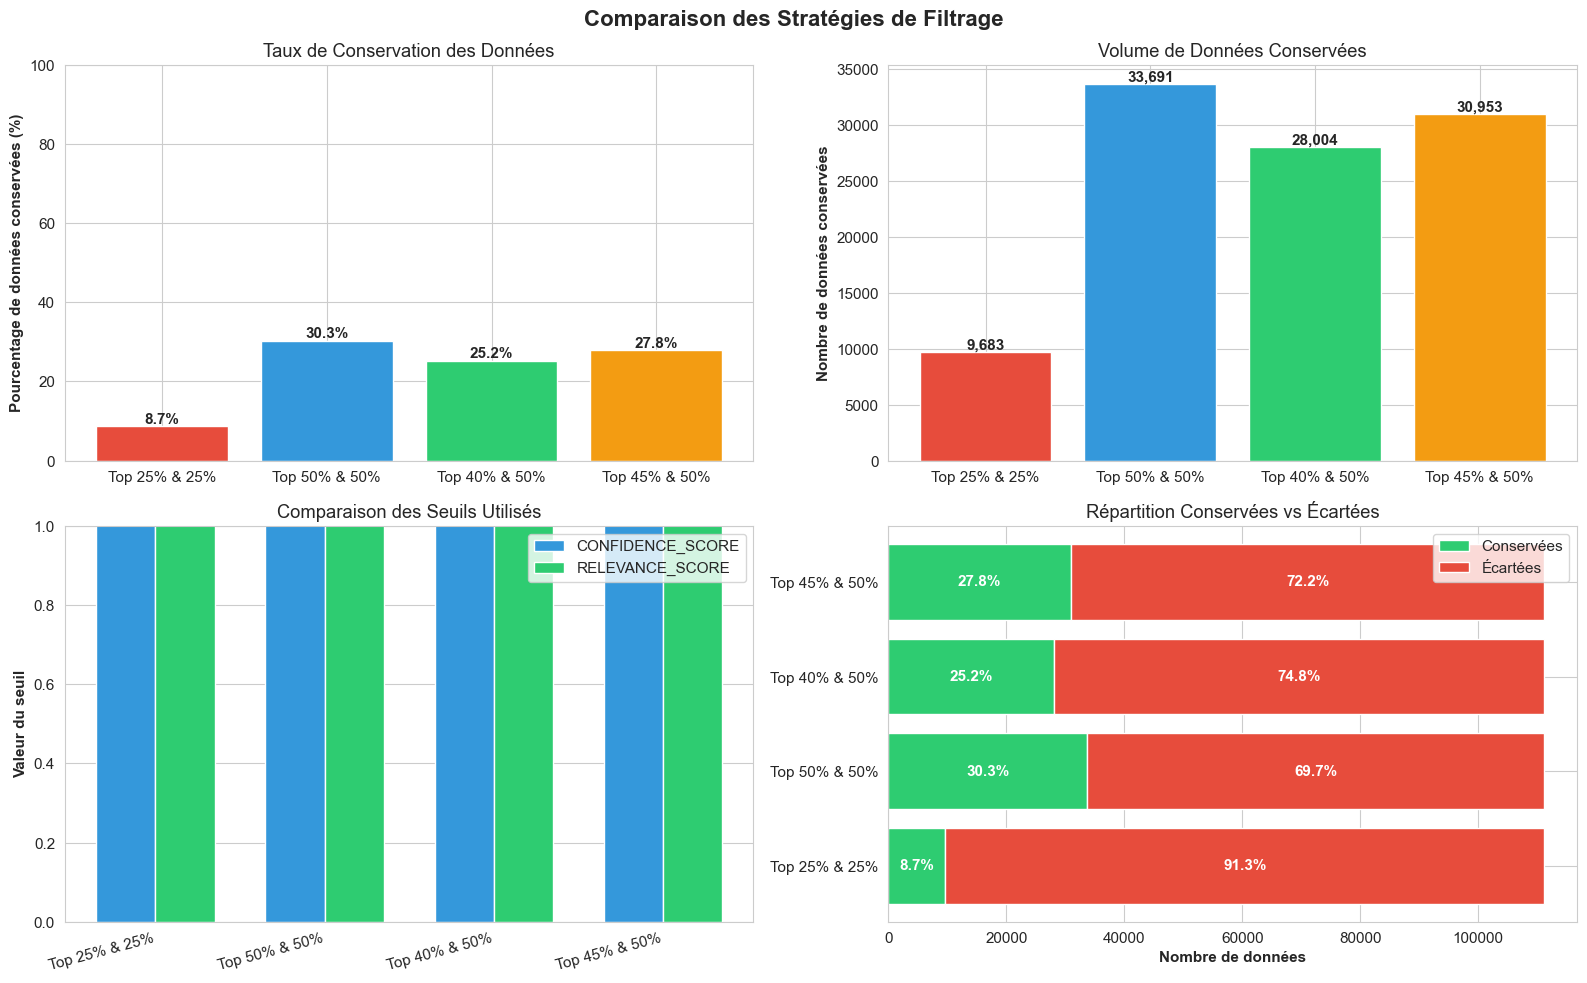


TABLEAU RÉCAPITULATIF
Stratégie            Conf Seuil   Rel Seuil    Conservées      %       
--------------------------------------------------------------------------------
Top 25% & 25%        89.989       68.086       9,683           8.7     %
Top 50% & 50%        74.978       58.746       33,691          30.3    %
Top 40% & 50%        81.630       58.746       28,004          25.2    %
Top 45% & 50%        78.320       58.746       30,953          27.8    %


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Préparer les données pour tous les tests
tests = []

# TEST 1
conf_th = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.75)
rel_th = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.75)
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= conf_th) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= rel_th)
]
tests.append({
    'nom': 'Top 25% & 25%',
    'conf_seuil': conf_th,
    'rel_seuil': rel_th,
    'conserve': len(df_filtered),
    'pourcentage': len(df_filtered)/len(df_reviews_calculated)*100
})

# TEST 2
conf_th = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.50)
rel_th = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.50)
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= conf_th) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= rel_th)
]
tests.append({
    'nom': 'Top 50% & 50%',
    'conf_seuil': conf_th,
    'rel_seuil': rel_th,
    'conserve': len(df_filtered),
    'pourcentage': len(df_filtered)/len(df_reviews_calculated)*100
})

# TEST 3
conf_th = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.60)
rel_th = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.50)
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= conf_th) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= rel_th)
]
tests.append({
    'nom': 'Top 40% & 50%',
    'conf_seuil': conf_th,
    'rel_seuil': rel_th,
    'conserve': len(df_filtered),
    'pourcentage': len(df_filtered)/len(df_reviews_calculated)*100
})

# TEST 4
conf_th = df_reviews_calculated['CONFIDENCE_SCORE'].quantile(0.55)
rel_th = df_reviews_calculated['RELEVANCE_SCORE'].quantile(0.50)
df_filtered = df_reviews_calculated[
    (df_reviews_calculated['CONFIDENCE_SCORE'] >= conf_th) & 
    (df_reviews_calculated['RELEVANCE_SCORE'] >= rel_th)
]
tests.append({
    'nom': 'Top 45% & 50%',
    'conf_seuil': conf_th,
    'rel_seuil': rel_th,
    'conserve': len(df_filtered),
    'pourcentage': len(df_filtered)/len(df_reviews_calculated)*100
})

# Créer les graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparaison des Stratégies de Filtrage', fontsize=16, fontweight='bold')

# Graphique 1 : Pourcentage de données conservées
ax1 = axes[0, 0]
noms = [t['nom'] for t in tests]
pourcentages = [t['pourcentage'] for t in tests]
bars1 = ax1.bar(noms, pourcentages, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])
ax1.set_ylabel('Pourcentage de données conservées (%)', fontweight='bold')
ax1.set_title('Taux de Conservation des Données')
ax1.set_ylim(0, 100)
# Ajouter les valeurs sur les barres
for bar, pct in zip(bars1, pourcentages):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Graphique 2 : Nombre absolu de données conservées
ax2 = axes[0, 1]
conserves = [t['conserve'] for t in tests]
bars2 = ax2.bar(noms, conserves, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])
ax2.set_ylabel('Nombre de données conservées', fontweight='bold')
ax2.set_title('Volume de Données Conservées')
# Ajouter les valeurs sur les barres
for bar, val in zip(bars2, conserves):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:,}', ha='center', va='bottom', fontweight='bold')

# Graphique 3 : Comparaison des seuils
ax3 = axes[1, 0]
x = range(len(tests))
conf_seuils = [t['conf_seuil'] for t in tests]
rel_seuils = [t['rel_seuil'] for t in tests]
width = 0.35
ax3.bar([i - width/2 for i in x], conf_seuils, width, label='CONFIDENCE_SCORE', color='#3498db')
ax3.bar([i + width/2 for i in x], rel_seuils, width, label='RELEVANCE_SCORE', color='#2ecc71')
ax3.set_ylabel('Valeur du seuil', fontweight='bold')
ax3.set_title('Comparaison des Seuils Utilisés')
ax3.set_xticks(x)
ax3.set_xticklabels(noms, rotation=15, ha='right')
ax3.legend()
ax3.set_ylim(0, 1)

# Graphique 4 : Données écartées vs conservées
ax4 = axes[1, 1]
total = len(df_reviews_calculated)
for i, test in enumerate(tests):
    conserve = test['conserve']
    ecarte = total - conserve
    ax4.barh(i, conserve, color='#2ecc71', label='Conservées' if i == 0 else '')
    ax4.barh(i, ecarte, left=conserve, color='#e74c3c', label='Écartées' if i == 0 else '')
    # Ajouter les pourcentages
    ax4.text(conserve/2, i, f"{test['pourcentage']:.1f}%", 
             ha='center', va='center', fontweight='bold', color='white')
    ax4.text(conserve + ecarte/2, i, f"{100-test['pourcentage']:.1f}%", 
             ha='center', va='center', fontweight='bold', color='white')

ax4.set_yticks(range(len(tests)))
ax4.set_yticklabels(noms)
ax4.set_xlabel('Nombre de données', fontweight='bold')
ax4.set_title('Répartition Conservées vs Écartées')
ax4.legend()

plt.tight_layout()
plt.show()

# Afficher aussi un tableau récapitulatif
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF")
print("="*80)
print(f"{'Stratégie':<20} {'Conf Seuil':<12} {'Rel Seuil':<12} {'Conservées':<15} {'%':<8}")
print("-"*80)
for test in tests:
    print(f"{test['nom']:<20} {test['conf_seuil']:<12.3f} {test['rel_seuil']:<12.3f} "
          f"{test['conserve']:<15,} {test['pourcentage']:<8.1f}%")
print("="*80)

#### 📊 Analyse et Synthèse
1. Écart important entre CONFIDENCE et RELEVANCE
* CONFIDENCE_SCORE : seuils très élevés (75-90%)
* RELEVANCE_SCORE : seuils plus bas (58-68%)
* Interprétation : les avis sont globalement confiants, mais moins souvent pertinents

2. Impact important du top 25% :
* on passe de 8.7% (top 25%) à 30.3% (top 50%). Soit +21.6 points de différence !
* Cela montre que beaucoup d'avis "pertinents" se situent entre le top 50% et le top 25%

3. Les seuils intermédiaires se comportent bien
* Top 40% & 50% : 25.2% de données
* Top 45% & 50% : 27.8% de données
Progression cohérente et prévisible

##### 🎯 Top 45% & 50% : 27.8% de données
Équilibre optimal : 27.8% des données (~31,000 avis)
* Assez restrictif pour garantir la qualité
* Assez souple pour avoir un volume exploitable

Seuils raisonnables :
* CONFIDENCE ≥ 78.3% : Avis plutôt fiables
* RELEVANCE ≥ 58.8% : Avis moyennement pertinents et plus

Volume exploitable : 31,000 avis, c'est largement suffisant pour :
* Analyses statistiques robustes
* Segmentations par produit/catégorie

Les seuils sur lesquels nous tombons dans cette analyse, montre qu'on est pas loin des seuils prédéfinis dans la première analyse, qui etaient :
* Confidence Score ≥ 70%.
* Relevance Score ≥ 50%.

Les seuils de l’analyse 1 sont plus permissifs et capturent plus de données, mais potentiellement moins fiables ou moins pertinentes.

#### 💡 Synthèse :
En examinant la distribution globale, des seuils initiaux de confiance ≥70% et pertinence ≥50% permettent d’avoir une vision générale. Toutefois, en se basant sur la distribution réelle des avis, des seuils plus stricts (Confidence ≥78,3% et Relevance ≥58,8%) permettent de capturer un sous-ensemble d’avis plutôt fiables et pertinents, représentant 27,8% des données. Ces seuils sont donc recommandés pour les analyses nécessitant des avis de qualité, tandis que les seuils plus permissifs peuvent être utilisés pour des analyses exploratoires plus larges.


In [26]:
df_reviews_calculated.head(2)

,REVIEW_ID,BUYER_ID,P_ID,PRODUCT_NAME,CATEGORY,TITLE,DESCRIPTION,RATING,TEXT_LENGTH,HAS_IMAGE,HAS_ORDERS,TEXT_LENGTH_SCORE,IS_EXTREME_RATING,KEYWORD_SCORE,RELEVANCE_SCORE,CATEGORY_REVIEW,CONFIDENCE_SCORE
0,96008,1d9275fd930c2c9b08cb4a162b576e6ce21ee7359b3d6e...,B078WYZK74,Camille Beckman All Natural Cocoa Butter Lip B...,All Beauty,A Great Product,"I bought one and after trying it, I bought thr...",5,87,False,True,0.567161,1,0.50000,54.514823,product quality or satisfaction,40.748632
1,96016,1e5631dbed5a85bfe3749aea4180b5835597ab5e871d19...,B01M1OBRBQ,"Real Techniques Bold Metals: Diamond Sponge, C...",All Beauty,Diamonds,I usually use the orange Real Techniques makeu...,5,376,False,True,0.930345,1,0.95925,76.891594,product quality or satisfaction,93.760085


In [9]:
# Create a new column 'RELEVANT_STATUS' to indicate if a review is relevant or not
# A review is considered relevant if confidence_score >= 78.3 and relevance_score >= 58.8
df_reviews_calculated["RELEVANT_STATUS"] = df_reviews_calculated.apply(
    lambda row: "RELEVANT" if (row["CONFIDENCE_SCORE"] >= 78.3 and row["RELEVANCE_SCORE"] >= 58.8)
    else "IRRELEVANT",
    axis=1
)

# Count the number of relevant and irrelevant reviews
relevant_counts = df_reviews_calculated["RELEVANT_STATUS"].value_counts()

# Display the counts for each category
print("Counts of Relevant vs Irrelevant reviews:")
print(relevant_counts)

Counts of Relevant vs Irrelevant reviews:
RELEVANT_STATUS
IRRELEVANT    80289
RELEVANT      30896
Name: count, dtype: int64


### 3.3 Nettoyage & Préparation pour sauvegarde dans Snowflake

In [10]:
# We will convert certain columns to boolean
bool_cols = ['HAS_IMAGE', 'HAS_ORDERS', 'IS_EXTREME_RATING']

for col in bool_cols:
    df_reviews_calculated[col] = df_reviews_calculated[col].astype(bool)

---
## 4️⃣ Sauvegarde des résultats dans Snowflake

### 4.1 Création de la table review_relevant dans Snowflake

Dans cette étape, nous préparons la base de données pour stocker les résultats enrichis des reviews.
Nous allons créer une table review_relevant si elle n’existe pas déjà, avec toutes les colonnes nécessaires pour conserver les informations des reviews, les scores calculés, la classification et le statut de pertinence.

In [11]:
# Define the SQL query to create the table if it does not exist
create_table_query = """
CREATE TABLE IF NOT EXISTS staging.review_relevant (
    REVIEW_ID INT,
    BUYER_ID STRING,
    P_ID STRING,
    PRODUCT_NAME STRING,
    CATEGORY STRING,
    TITLE STRING,
    DESCRIPTION STRING,
    RATING FLOAT,
    TEXT_LENGTH INT,
    HAS_IMAGE BOOLEAN,
    HAS_ORDERS BOOLEAN,
    TEXT_LENGTH_SCORE FLOAT,
    IS_EXTREME_RATING BOOLEAN,
    KEYWORD_SCORE FLOAT,
    RELEVANCE_SCORE FLOAT,
    CATEGORY_REVIEW STRING,
    CONFIDENCE_SCORE FLOAT,
    RELEVANT_STATUS STRING
);
"""

# Open a cursor to execute SQL queries in Snowflake
cur = conn.cursor()

# Execute the create table query
cur.execute(create_table_query)

# Close the cursor to free resources
cur.close()


True

### 4.2 Insertion des données dans Snowflake
Dans cette dernière étape, nous allons enregistrer les reviews enrichies et filtrées dans la table REVIEW_RELEVANT de Snowflake.
Nous utilisons la fonction write_pandas qui permet d’insérer directement un DataFrame Pandas dans une table Snowflake, en gérant automatiquement le découpage en chunks si nécessaire.

In [12]:
from snowflake.connector.pandas_tools import write_pandas
import pandas as pd 


In [14]:
import sys
print(sys.executable)


e:\jedha-certification-de\project_2\src_code\amz-etl\Scripts\python.exe


In [ ]:

# Write the DataFrame to Snowflake table 'REVIEW_RELEVANT'
# This function returns:
# - success: True if all chunks inserted successfully
# - nchunks: number of chunks used for insertion
# - nrows: number of rows inserted
success, nchunks, nrows, _ = write_pandas(conn, df_reviews_calculated, 'STAGING.REVIEW_RELEVANT')

# Print confirmation of the number of rows inserted
print(f"✅ Insertion completed: {nrows} rows inserted into Snowflake.")

# Close the Snowflake connection to free resources
conn.close()
print("🔒 Snowflake connection closed.")


✅ Insertion completed: 111185 rows inserted into Snowflake.
🔒 Snowflake connection closed.


---
### 5️⃣ Dashboards et visualisation


Pour la suite, nous allons exploiter les données enrichies et stockées dans Snowflake afin de créer des dashboards interactifs.
Les principaux outils que nous utiliserons sont :
 - Snowflake : pour centraliser les données, effectuer des requêtes analytiques et préparer des vues agrégées.
 - Streamlit : pour construire des applications et dashboards interactifs permettant de visualiser les reviews, les scores de pertinence, la distribution des catégories et d’autres insights clés.

Cette approche permettra de :
 - Visualiser rapidement les avis pertinents par produit ou par catégorie.
 - Suivre la répartition des scores de confiance et de pertinence.
 - Fournir une interface simple et interactive pour les équipes métier ou décisionnelles.

Ainsi, toutes les analyses et visualisations futures seront basées sur les données déjà calculées et stockées dans Snowflake, garantissant efficacité et cohérence des informations affichées.

---
## 📚 RÉFÉRENCES

- [Hugging Face - Zero-Shot Classification](https://huggingface.co/tasks/zero-shot-classification)
- [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment)
- [Snowflake Python Connector Docs](https://docs.snowflake.com/en/user-guide/python-connector)
- [Streamlit Documentation](https://docs.streamlit.io)
- [BART Model Paper](https://arxiv.org/abs/1910.13461)
- [mDeBERTa Model](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7)